In [44]:
import numpy as np 
from PIL import Image,ImageOps
import matplotlib.pyplot as plt
from collections import defaultdict

#### Zadanie 1 Analiza obrazów  
• Wczytaj obraz przedstawiający tekst, dokonaj odwrócenia kolorów (czarne tło), a następnie jego transformacji do domeny częstotliwościowej za pomocą DFT. Przedstaw wartości fazy i modułu współczynników Fouriera (osobno).  
• Wybierz przykładowego reprezentanta grupy - wytnij z dużego zdjęcia wzorzec obiektu np. literę e lub charakterystyczny fragment ryby z ławicy (imcrop).  
• Wykorzystując transformację Fouriera oblicz korelację między wybranym wzorcem, a całym obrazem 1  
• Przedstaw otrzymany obraz wyjściowy oraz punkty, w których wykryto wystąpienie wzorca (nałóż je na obraz oryginalny).  
• Znajdź liczbę wystąpień wzorca. Testy przeprowadź na dwóch zbiorach danych.


In [208]:
def findPattern(image,pattern,changeImage,mu=0.95):
    originalImage = Image.open(image)
    w,h = originalImage.size
    img = changeImage(originalImage) 
    
    imgPattern = Image.open(pattern)
    wp,hp = imgPattern.size
    imgPattern = changeImage(imgPattern)

    img = np.swapaxes(np.array(img),0,1)
    imgPattern = np.swapaxes(np.array(imgPattern),0,1)

    correlation = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(img),
                np.fft.fft2(np.rot90(imgPattern,2), s=(w,h)))))
    
    pixels = originalImage.load()
    pixels2 = originalImage.copy().load()  

    matchCondition = mu * np.max(correlation)
    matches = np.argwhere(correlation >= matchCondition)

    for x, y in matches:
        x = int(x)
        y = int(y)
        for i in range(wp):
            for j in range(hp):
                r, g, b = pixels2[x-i,y-j] #orginalne kolory
                pixels[x-i,y-j] = (r, g-100, b-100) 
        
    print("Liczba wystąpień wzorca:",len(matches))   
    plt.figure(figsize=(20,10))
    plt.axis('off')
    plt.imshow(np.asarray(originalImage))

Liczba wystąpień wzorca: 43


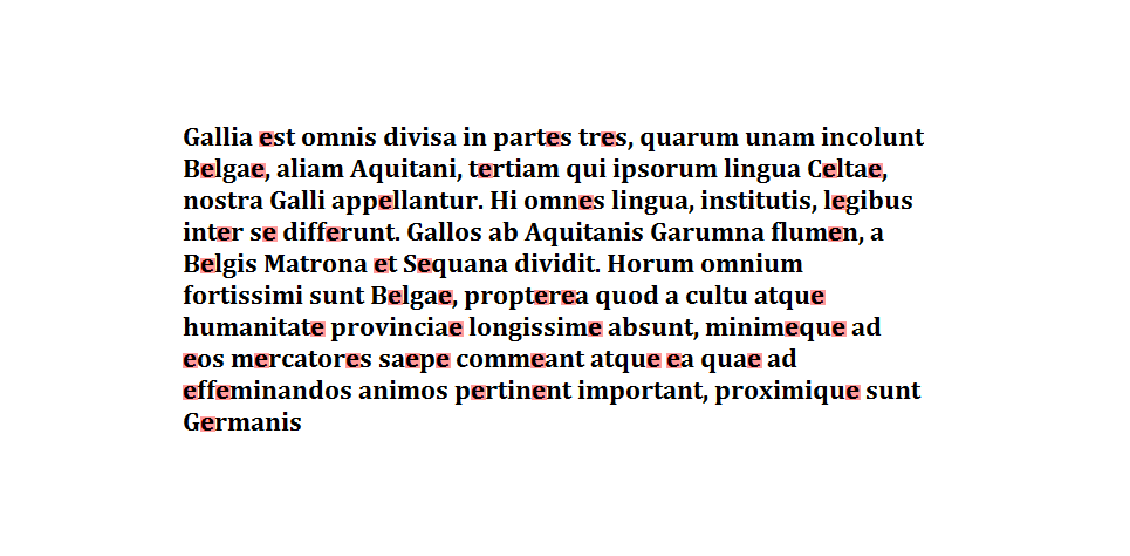

In [209]:
findPattern(image="galia.png",pattern="galia_e.png",changeImage=lambda i: ImageOps.invert(i.convert('L')))

Liczba wystąpień wzorca: 64550


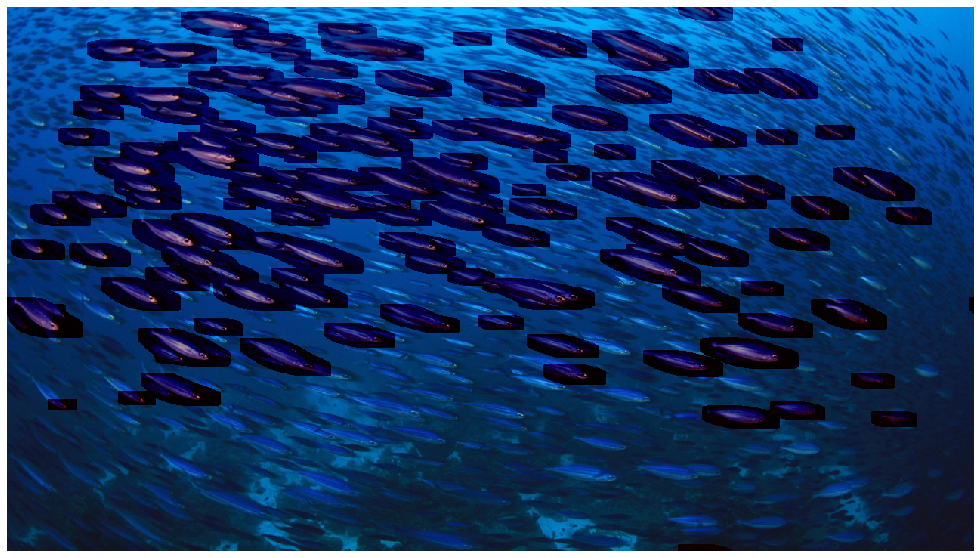

In [210]:
findPattern(image="school.jpg",pattern="fish1.png",changeImage=lambda i: np.array(i)[:,:,0],mu=0.145) 

#### Zadanie 2 OCR
Napisz program przekształacający obraz w tekst, przyjmując następujące założenia:
1. Na obrazie znajduje się tekst złożony z małych liter alfabetu łacińskiego oraz cyfr
2. Na obrazie występuje jeden typ i rozmiar czcionki
3. Weź pod uwagę czcionki szeryfowe i bezszeryfowe
4. W tekście występują znaki przestankowe: .,?!
5. Tekst składa się z wielu linii
6. Tekst może być obrócony (krzywo zeskanowany w całości)
7. Program powinien zwracać tekst wraz ze znakami białymi i znakami nowych linii
8. Program może raportować procent poprawnie rozpoznanych liter dla pre-definiowanych obrazów testowych
9. Program powinien dodatkowo zliczać liczbę wystąpień każdej litery
10. Należy zastosować operację splotu i DFT albo inne metody (klasyfikacja)
11. Należy dokonać redukcji szumu na obrazie wejściowym

In [111]:
def trim(img, color='white'):
    background = Image.new(img.mode, img.size, color)
    diff = ImageChops.difference(img, background)
    bbox = diff.getbbox()
    if bbox:
        return img.crop(bbox)
    return img

def OCR(image,fontFamilly,originalText):
    characters = string.ascii_lowercase + string.digits + '.,?!'
    
    try:
        font = ImageFont.truetype('C:\Windows\Fonts\{}.ttf'.format(fontFamilly),40)
    except OSError:
        eprint('Font "{}" not found'.format(font_family))
        raise SystemExit

    originalImage = Image.open(image)
    w,h = originalImage.size
    img = ImageOps.invert(originalImage.convert('L'))    
    img = np.swapaxes(np.array(img),0,1)

    recognized = []

    for char in characters:
        wp,hp = font.getsize(char)
        imgPattern = Image.new('RGB',(wp,hp),color='white')
        ImageDraw.Draw(imgPattern).text((0,0),char,font=font,fill='black')
        imgPattern = ImageOps.invert(imgPattern.convert('L'))    
        imgPattern = np.swapaxes(np.array(imgPattern),0,1)
        
        C = np.real(np.fft.ifft2(np.multiply(np.fft.fft2(img),
                    np.fft.fft2(np.rot90(imgPattern,2), s=(w,h)))))
    
        mu = 0.998
        matchCondition = mu * np.max(C)
        
        pixels = originalImage.load()

    # TODO - do przerobienia (ulepszenia xd)
        for x in range(w):
            for y in range(h):
                if C[x][y] > matchCondition:
                    x0, y0 = x-wp, y-hp
                    recognized.append((x0, y0, C[x][y], char, wp, hp))

    (i_width, i_height), (space_width, _) = map(font.getsize, ['i', ' '])
    xdiv, ydiv = i_width, i_height // 3
    buckets = defaultdict(dict)
    for one in recognized:
        x, y, C, char, wp, hp = one
        bx, by = x // xdiv, y // ydiv
        if by not in buckets or bx not in buckets[by] or buckets[by][bx][0] < C:
            buckets[by][bx] = one

    counter = {}
    dr, dg, db = (-100,0,-100)
    result = ""
    
    for by in sorted(buckets):
        prev = None
        for bx in sorted(buckets[by]):
            x, y, C, char, wp, hp = buckets[by][bx]

            # insert whitespace
            if prev is not None:
                prev_x, _, _, prev_pattern, prev_pw, _ = prev
                if prev_x + prev_pw + space_width * 0.8 < x:
                    result += ' '
                    print(' ', end='')
            # ignore free commas and dots
            elif char in ',.':
                continue

            # print recognized character
            print(char, end='')
            result += char
            if char in counter:
                counter[char] += 1
            else:
                counter[char] = 1

            prev = buckets[by][bx]

        # insert newline if line is not empty
        if prev is not None:
            print('', end='\r\n')
            result += '\r\n'

    corr = 0
    for i in range (len(result)):
        if(result[i] == originalText[i]):
            corr += 1
    
    print("\nZgodność z orginałem: {:.2f}%".format(corr/len(originalText)*100))
        

In [112]:
originalText = "abcdefghijklmnopqrstuvwxyz 0123456789 ?!.,\n"
originalText += "lorem ipsum dolor sit amet, consectetur adipiscing elit,\n" 
originalText += "etiam arcu felis, dictum id molestie nec, sagittis quis massa."

OCR("full_Arial.png",'Arial', originalText)

ab diefgn jklm opqrstuvwxyz 01234i56789 ?!
lorem psum diolor s t a,met o se tetur a,di p s g el t
et am ar u fel s di tum di molest e e sag tt s qu s massa

Zgodność z orginałem: 25.31%


In [24]:
from PIL import Image, ImageFont, ImageDraw, ImageOps, ImageChops
import string

def generate_image(
    text='Lorem ipsum sit dolor amet.',
    font_family='Arial',
    font_size=40,
    path='Lorem_Arial.png'
):
    font = ImageFont.truetype('C:\Windows\Fonts\{}.ttf'.format(font_family), font_size)
    width, height = 0, 0
    for line in text.split('\n'):
        w, h = font.getsize(line)
        width = max(width, w)
        height += h
    image = Image.new('RGB', (width, height), color='white')
    ImageDraw.Draw(image).text((0, 0), text, font=font, fill='black')
    #image = ImageOps.invert(ImageOps.invert(image).rotate(4, expand=True))
    image = ImageOps.expand(image, border=30, fill='white')
    image.save(path)

if __name__ == "__main__":
    for font_family in ['Arial', 'Times']:
        for extension in ['png', 'jpg']:
            generate_image(
                text='lorem ipsum sit dolor amet.',
                font_family=font_family,
                path='short_{}.{}'.format(font_family, extension)
            )

            generate_image(
                text='\n'.join([
                    ' '.join([string.ascii_lowercase, string.digits, '?!.,']),
                    'lorem ipsum dolor sit amet, consectetur adipiscing elit.',
                    'etiam arcu felis, dictum id molestie nec, sagittis quis massa.'
                ]),
                font_family=font_family,
                path='full_{}.{}'.format(font_family, extension)
            )